<a href="https://colab.research.google.com/github/anselmo-pitombeira/Notebooks/blob/master/Iteracao_valor_controle_estoques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aplicação de processos de decisão markovianos ao problema de controle de estoque

Neste notebook, produzimos uma política de decisão ótima para o problema de controle de estoques por meio do método de iteração de valor.

O conjunto de estados é $\mathcal{S} = \{0, 1, ..., n\}$, que corresponde às possíveis quantidades em estoque. A cada dia, um tomador de decisão observa o nível de estoque $s_t$ e decide se repõe ou não o estoque. No caso de reposição, o estoque é preenchido até a quantidade máxima $n$. O conjunto de decisões é portanto $\mathcal{A} = \{0,1\}$, em que 0 significa "não repor" e 1 significa "repor". 

A cada dia, uma quantidade demandada $d_t$ consome o estoque de acordo com uma distribuição de Poisson com média $\mu$. A transição de estados ocorre então de acordo com o seguinte sistema dinâmico:
\begin{equation}
	s_{t+1} = \max\{0, s_t-d_t+a_t(n-s_t)\},
\end{equation}
em que $a_t \in \{0,1\}$ é a decisão tomada. Após essa decisão, o tomador de decisão paga um custo dado por
\begin{equation}
	r(s_t,a_t) = k_1 \max\{0,s_t-d_t+a_t(n-s_t)\}+k_2 |\min\{0,s_t-d_t+a_t(n-s_t)\}|
\end{equation}
em que $k_1$ é o custo unitário de manter estoque e $k_2$ é o custo unitário por cada unidade de demanda não atendida.

O objetivo é encontrar uma política de decisão $\pi: \mathcal{S} \to \{0,1\}$ que associa cada nível de estoque a uma decisão de repor ou não o estoque de forma a minimizar o valor esperado do custo acumulado ao longo do tempo:
\begin{equation}
	\min_{\pi} v(s_0) = \lim_{T \to \infty} \mathbb{E}\Bigg[\sum_{t=0}^{T} \gamma^t r(s_t,\pi(s_t))\Bigg],
\end{equation}
em que $0<\gamma <1$ é um fator de desconto.


## Importação das bibliotecas

In [ ]:
import numpy as np
import numpy.random as rd
from numba import njit

## Definição da função que executa a iteração de valor

In [ ]:
@njit
def iteracao_valor(S,A,demanda_media,k1,k2,gamma,m,seed,n_iter,tol):

    rd.seed(seed)           ##Seta a seed do gerador de números aleatórios
    v = np.zeros(len(S))    ##Vetor que guarda a função de valor

    for j in range(n_iter):

        v_novo = np.zeros(len(S))    ##Guarda os valores atualizados da função de valor
        politica = np.zeros(len(S))        ##Guarda a decisão em cada estado

        for i in S:
            valor_decisao = []

            for a in A:
                soma = 0
                ##Aproxima o valor esperado por simulação:
                for k in range(m):
                    d = rd.poisson(demanda_media)             ##Amostra a demanda
                    if d > 10*demanda_media:
                        d = 10*demanda_media
                    prox_estado = max(0,i-d+a*(n-i))           ##Computa próximo estado pelo modelo dinâmico
                    estoque = prox_estado
                    perda = abs(min(0, i-d+a*(n-i)))
                    custo_imediato = k1*estoque+k2*perda
                    valor_simulado = custo_imediato+gamma*v[prox_estado]
                    soma+=valor_simulado

                valor_esperado = soma/m
                valor_decisao.append(valor_esperado)

            ##identifica o menor valor
            valor_decisao = np.array(valor_decisao)
            min_valor = np.min(valor_decisao)
            melhor_decisao = np.argmin(valor_decisao)

            ##Atualiza a função de valor para o estado i
            v_novo[i] = min_valor
            politica[i] = melhor_decisao

        ##Testa critério de parada
        diff = np.max(np.abs(v - v_novo))
        print(diff)
        if diff <  tol:
            v = v_novo
            break
        else:
            v = v_novo

    return v, politica

## Parâmetros

In [ ]:
n = 30                ##Capacidade máxima de armazenagem do estoque
S = list(range(n+1))  ##Espaço de estados
A = [0,1]             ##Espaço de decisões: 1 -> repor, 0 -> não repor
k1 = 1                ##Custo de manter estoques
k2 = 5               ##Custo de não atendimento da demanda
demanda_media = 10    ##Demanda média diária (segue uma distribuição de Poisson)
gamma = 0.9           ##Fator de desconto
seed = 42             ##Semente do gerador de números aleatórios
m = 1000               ##Tamanho da amostra na aproximação do valor esperado
n_iter = 100         ##Número máximo de iterações
tol = 0.01            ##Tolerância

## Roda a iteração de valor

In [ ]:
f_valor, politica = iteracao_valor(S,A,demanda_media,k1,k2,gamma,m,seed,n_iter,tol)


## Política e função de valor ótimas

Política =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1.]


Text(0, 0.5, 'Função de valor ótima')

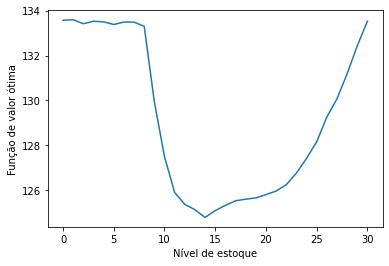

In [ ]:
print("Política = ", politica)
import matplotlib.pyplot as plt
plt.plot(f_valor)
plt.xlabel("Nível de estoque")
plt.ylabel("Função de valor ótima")